In [27]:
import numpy as np 
import pandas as pd
from itertools import *
from mip import *
from datetime import *
import re
from decimal import Decimal
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
def montar_arquivo(filename):
    """Função para ler o arquivo e gerar as estruturas de dados que serão consumidas pelo
    modelo de otimização"""

    conteudo = []

    with open(filename)  as f:
        for line in f:
            conteudo.append(line.strip('\n'))

    header = conteudo[0].split(' ')
    m = np.int32(header[1])
    n = np.int32(header[2])
    raw_data = {}
    for i in range(1, len(conteudo)):    
        raw_data[i] = conteudo[i].split(' ')

    dados = {}
    conjunto = []
    id = 0
    for k in raw_data.keys():
        aux = []
        for x in raw_data[k]:       
            if x != "" and x != 'capacity':
                aux.append(float(x))
            elif x == 'capacity':
                aux.append(-1)
        conjunto.append(aux)                
                
        
    demand_raw = []
    cost_raw = []
    count = 0
    conjunto = list(chain(*conjunto))
    for i in range(2*m, len(conjunto)):
        if count % (m+1) == 0:
            demand_raw.append(conjunto[i])
        else:
            cost_raw.append(conjunto[i])   
        count += 1         

   
    dict_capacity = {'a':[8000,10000,12000,14000], 'b': [5000,6000,7000,8000],
                    'c':[5000, 5750, 6500, 7250]}

    text = r'cap(\w)'
    letra = re.findall(text, filename)

    if letra[0] in ['a','b','c']:
        capacity = [dict_capacity[letra[0]][0] for i in range(m)]

    else:  
        capacity = [conjunto[i] for i in range(2*m) if i%2==0]
    cost_fixed = [conjunto[i] for i in range(2*m) if i%2==1]


    demand = demand_raw
    cost_prep = cost_raw

    cost = {}
    id = 0
    for i in range(n):
        aux = []
        for j in range(m):
            #print(i,j, id)    
            if id < (n*m):
                aux.append(cost_prep[id])         
            id += 1    
        cost[i] = aux
    return demand, capacity, cost, cost_fixed  

In [3]:
def solve_model(demand, capacity, cost, cost_fixed, filename, cut_plan = 'AUTOMATIC'):

    now = datetime.now()
    now = now.strftime("%Y-%m-%d_%H_%M_%S")

    cuts_types = {
              None: 0,
              'AUTOMATIC': -1, 
             'GOMORY': CutType.GOMORY,
              'KNAPSACK_COVER': CutType.KNAPSACK_COVER,
              'CLIQUE': CutType.CLIQUE,
              'LIFT': CutType.LIFT_AND_PROJECT}
    
    cut_code = cuts_types[cut_plan]

    model = Model()

    m = len(capacity)

    n = len(demand)

    model.store_search_progress_log = True

    x = [[model.add_var(name = f'x{i}{j}', lb = 0, ub = 1) for j in range(m)] for i in range(n)]

    y = [model.add_var(name = f'y{j}', var_type = BINARY) for j in range(m)]

    model.objective = xsum(y[j]*cost_fixed[j] for j in range(m)) +  xsum(x[i][j]*cost[i][j] for i in range(n) for j in range(m))

    for j in range(m):
        model += xsum(x[i][j]*demand[i] for i in range(n))<= capacity[j]*y[j]

    for i in range(n):
            model += xsum(x[i][j]*demand[i] for j in range(m))>= demand[i]

    for j in range(m):
        for i in range(n):
                model+= x[i][j]<=demand[i]*y[j]

    if cut_code == 0:
         model.cuts = 0    
    elif cut_plan in ['GOMORY', 'KNAPSACK_COVER', 'CLIQUE', 'LIFT']:
        if model.solver_name.lower() == "cbc":
            model.optimize(relax = True)
            cp = model.generate_cuts([CutType.GOMORY])
            if cp.cuts:
                model += cp
    else:
         model.cuts = -1                

    file = filename[8:13]            

    setting = f"{m*n}_{cut_plan}," 
    log =  f"log_{m*n}_{cut_plan}_{now}"                  
               

    model.write('capacitaded_problem.lp')

    model.optimize(max_seconds = 1500)
    progress = model.search_progress_log
    progress.instance = setting
    progress.write(f'./logs/{log}')
    results = model.objective_value
    return results

In [18]:
def tratar_arquivo_logs(filenames):

    tempo = {'Instancia':[],
        'Duracao': []}

    limites = {'Instancia':[],        
            'Lower_Bound': [],
            'Upper_Bound': []}

    for filename in filenames:
        conteudo = []
        with open(filename)  as f:
            for line in f:
                conteudo.append(line.strip(','))

        lista = conteudo[0].split(',')

        tempo['Instancia'].append(lista[0].split(':')[1].strip(' '))
        tempo['Duracao'].append(float(lista[1].split(':')[1].strip(' ')))  

        n = len(lista[2:])

        for i in range(2,n):    
            if i%2 == 0:
                limites['Instancia'].append(lista[0].split(':')[1].strip(' '))
                try:
                    value = float(lista[i])   
                except ValueError as ex:
                    value = float(lista[i].split('.')[0])  
                    if value == 1:
                        value = INF       
                limites['Lower_Bound'].append((value))
            else:
                try:
                    value = float(lista[i])
                except ValueError as ex:
                    value = float(lista[i].split('.')[0])
                    if value == 1:
                        value = INF 
                limites['Upper_Bound'].append(value)    

    df_limites = pd.DataFrame.from_dict(limites)
    df_duracao = pd.DataFrame.from_dict(tempo)
    return df_limites, df_duracao

In [144]:
log_files = glob.glob('./logs/*')

In [145]:
df_limites = tratar_arquivo_logs(log_files)[0]
df_tempos = tratar_arquivo_logs(log_files)[1]

In [146]:
df_tempos.describe()

,Duracao
count,36.000000
mean,0.027598
std,0.044660
min,0.000729
25%,0.001147
50%,0.001572
75%,0.060398
max,0.210878


In [147]:
df_tempos.head(3)

,Instancia,Duracao
0,100000_AUTOMATIC,0.055284
1,100000_AUTOMATIC,0.056896
2,100000_AUTOMATIC,0.060514


In [149]:
df_tempos_1 = df_tempos['Instancia'].str.split('_', expand = True)
df_tempos_1.columns = ['Size', 'CutType', 'Cut_type_2']
df_tempos_1 = pd.concat([df_tempos_1, df_tempos['Duracao']], axis = 1)
df_tempos_1['Duracao'] = df_tempos_1['Duracao'].apply(lambda x: 1000*x)
df_tempos_1.drop(columns = ['Cut_type_2'], inplace = True)

In [168]:
df_tempos_1['Size'].unique()

array(['100000', '1250', '800'], dtype=object)

In [150]:
df_tempos_1.describe()

,Duracao
count,36.000000
mean,27.597759
std,44.660104
min,0.729084
25%,1.146793
50%,1.572490
75%,60.397744
max,210.877895


Text(0.5, 0, 'Duracao (ms)')

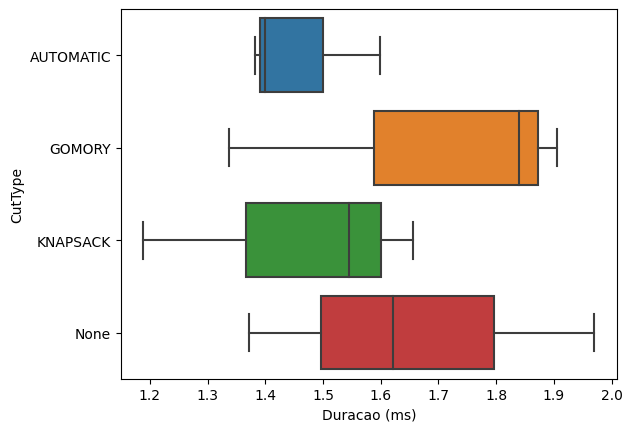

In [151]:
sns.boxplot(data = df_tempos_1[df_tempos_1['Size'] == '800'], x= 'Duracao', y = 'CutType')
plt.xlabel('Duracao (ms)')

Text(0.5, 0, 'Duracao (ms)')

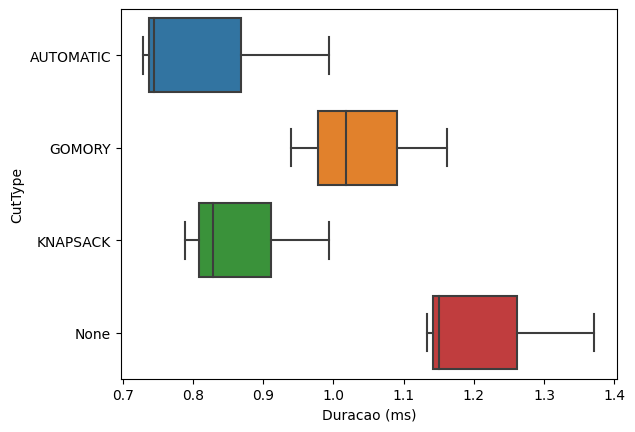

In [169]:
sns.boxplot(data = df_tempos_1[df_tempos_1['Size'] == '1250'], x= 'Duracao', y = 'CutType')
plt.xlabel('Duracao (ms)')

Text(0.5, 0, 'Duracao (ms)')

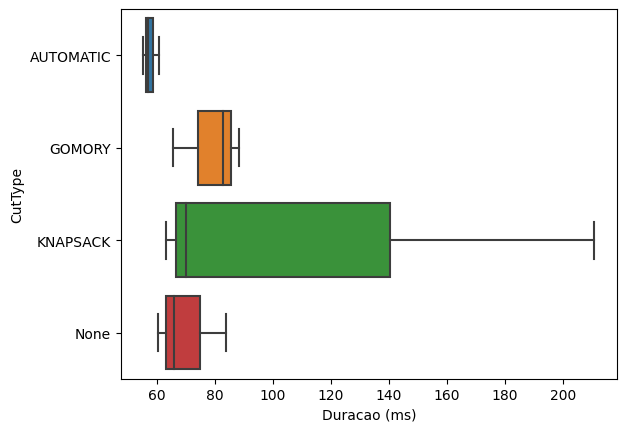

In [152]:
sns.boxplot(data = df_tempos_1[df_tempos_1['Size'] == '100000'], x= 'Duracao', y = 'CutType')
plt.xlabel('Duracao (ms)')

In [153]:
df_tempos_1.groupby(['Size', 'CutType']).mean()

Duracao
Size   CutType              
100000 AUTOMATIC   57.564656
       GOMORY      78.795433
       KNAPSACK   114.681959
       None        69.907029
1250   AUTOMATIC    0.821988
       GOMORY       1.039743
       KNAPSACK     0.870307
       None         1.218955
800    AUTOMATIC    1.460711
       GOMORY       1.694043
       KNAPSACK     1.463572
       None         1.654704

In [154]:
model = ols('Duracao ~ CutType', data = df_tempos_1[df_tempos_1['Size'] == '100000']).fit()
anova_table = sm.stats.anova_lm(model)
print(anova_table)

           df        sum_sq      mean_sq         F    PR(>F)
CutType   3.0   5427.830407  1809.276802  0.998159  0.441822
Residual  8.0  14500.912962  1812.614120       NaN       NaN


In [188]:
model = ols('Duracao ~ CutType + Size + CutType:Size', data = df_tempos_1).fit()
anova_table = sm.stats.anova_lm(model)
print(anova_table)
anova_table.to_excel('./output/anova_duracao.xlsx')

                df        sum_sq       mean_sq          F        PR(>F)
CutType        3.0   1799.548832    599.849611   0.992748  4.130129e-01
Size           2.0  49878.547881  24939.273941  41.274349  1.705914e-08
CutType:Size   6.0   3628.711323    604.785220   1.000916  4.475014e-01
Residual      24.0  14501.563059    604.231794        NaN           NaN


c:\Users\CG395UV\OneDrive - EY\Documents\Doutorado_JP\Programacao_Linear\pl\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  


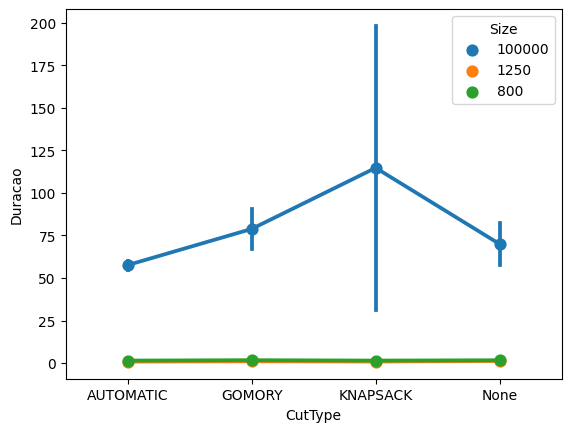

In [170]:
# Plot main effects
sns.pointplot(x='CutType', y='Duracao', hue='Size', data=df_tempos_1, ci='sd')
plt.xlabel('CutType')
plt.ylabel('Duracao')
plt.legend(title='Size')
plt.show()

c:\Users\CG395UV\OneDrive - EY\Documents\Doutorado_JP\Programacao_Linear\pl\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  


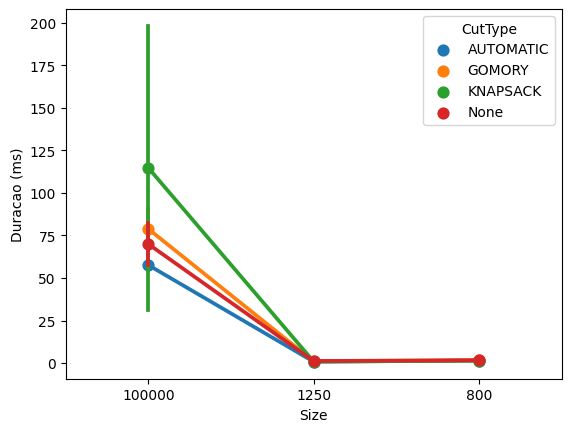

In [171]:
# Plot main effects
sns.pointplot(x='Size', y='Duracao', hue='CutType', data=df_tempos_1, ci='sd')
plt.xlabel('Size')
plt.ylabel('Duracao (ms)')
plt.legend(title='CutType')
plt.show()

In [159]:
df_limites['Gap'] = df_limites.apply(lambda x: abs((x['Upper_Bound']- x['Lower_Bound'])/x['Upper_Bound']), axis = 1)

In [160]:
df_limites.describe()

c:\Users\CG395UV\OneDrive - EY\Documents\Doutorado_JP\Programacao_Linear\pl\lib\site-packages\numpy\lib\function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,Lower_Bound,Upper_Bound,Gap
count,2.170000e+02,217.0,1.450000e+02
mean,1.233232e+07,inf,1.929762e-02
std,8.212634e+06,NaN,8.642552e-03
min,6.769126e+05,928941.0,3.604231e-07
25%,1.033597e+06,19261874.0,2.226722e-02
50%,1.883297e+07,19287182.0,2.335208e-02
75%,1.883297e+07,NaN,2.355017e-02
max,1.883297e+07,inf,2.355017e-02


In [161]:
df_limites_1 = df_limites['Instancia'].str.split('_', expand = True)
df_limites_1.columns = ['Size', 'CutType', 'Cut_type_2']
df_limites_1 = pd.concat([df_limites_1, df_limites['Gap']], axis = 1)
df_limites_1['Gap'] = df_limites_1['Gap'].apply(lambda x: 100*x)
df_limites_1.drop(columns = ['Cut_type_2'], inplace = True)

In [162]:
df_limites_2 = df_limites_1['Gap'].dropna(inplace = True)

In [163]:
df_limites_1.groupby(['Size', 'CutType']).mean()

Gap
Size   CutType            
100000 AUTOMATIC  2.334796
       GOMORY     2.279301
       KNAPSACK   2.292608
       None       2.338269
1250   AUTOMATIC  0.000081
       GOMORY     0.000081
       KNAPSACK   0.000081
       None       0.000081
800    AUTOMATIC  0.000036
       GOMORY     0.000036
       KNAPSACK   0.000036
       None       0.000036

Text(0.5, 0, 'Gap (%)')

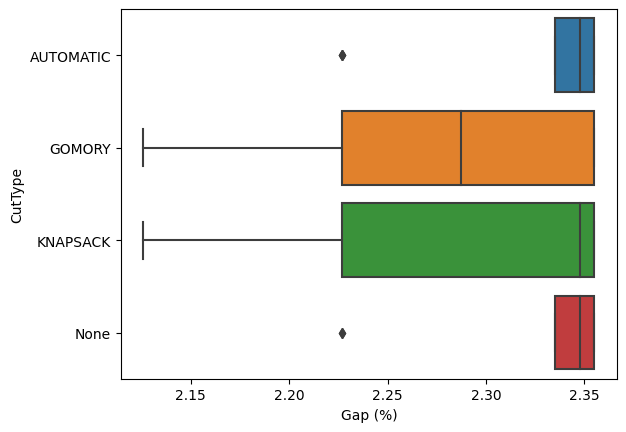

In [164]:
sns.boxplot(data = df_limites_1[df_limites_1['Size'] == '100000'], x= 'Gap', y = 'CutType')
plt.xlabel('Gap (%)')

In [182]:
model = ols('Gap ~ CutType + Size + CutType:Size', data = df_limites_1).fit()
anova_table = sm.stats.anova_lm(model)
print(anova_table)
anova_table.to_excel('./output/anova_gap.xlsx')

                 df      sum_sq    mean_sq             F         PR(>F)
CutType         3.0    0.243096   0.081032     28.227705   3.443860e-14
Size            2.0  106.920761  53.460380  18623.069913  1.433130e-163
CutType:Size    6.0    0.013293   0.002216      0.771794   5.934031e-01
Residual      133.0    0.381797   0.002871           NaN            NaN


c:\Users\CG395UV\OneDrive - EY\Documents\Doutorado_JP\Programacao_Linear\pl\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  


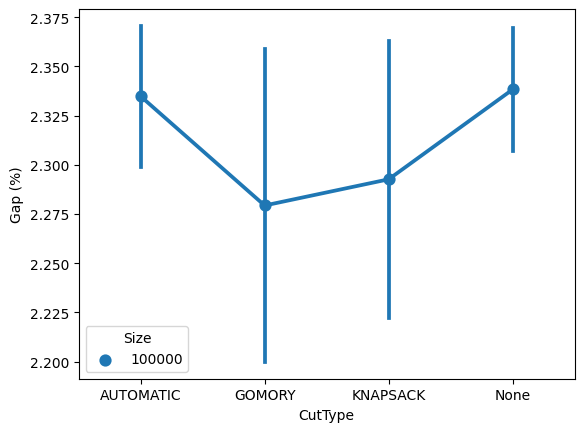

In [175]:
# Plot main effects
sns.pointplot(x='CutType', y='Gap', hue='Size', data=df_limites_1[df_limites_1['Size']=='100000'], ci='sd')
#plt.title('Main Effects Plot')
plt.xlabel('CutType')
plt.ylabel('Gap (%)')
#plt.legend(title='Size')
plt.show()

c:\Users\CG395UV\OneDrive - EY\Documents\Doutorado_JP\Programacao_Linear\pl\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  


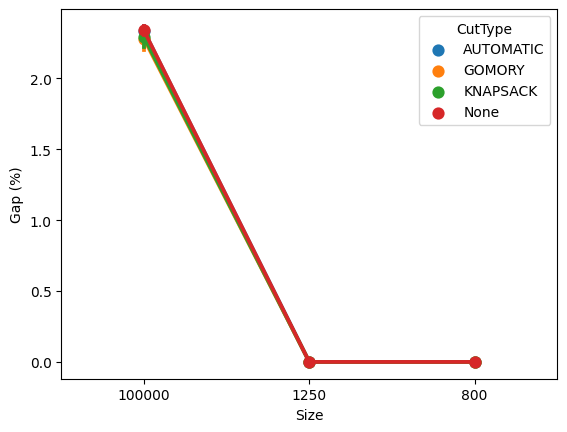

In [176]:
# Plot main effects
sns.pointplot(x='Size', y='Gap', hue='CutType', data=df_limites_1, ci='sd')
#plt.title('Main Effects Plot')
plt.xlabel('Size')
plt.ylabel('Gap (%)')
plt.legend(title='CutType')
plt.show()